# Bayesian Inference of Mock NBA Draft Order

Many of us who follow the NBA Draft closely have a keen desire to know the precise ordering of the Draft, eg where each player will be taken ("where" having a dual meaning here, both the team and draft slot). To this end, it is common behavior to ingest the information we get from the dozen or more "prominent" mock drafts available leading up to the Draft. There are different ways analysts and media try to aggregate this information into what I like to call "Meta Mocks". Typically this just involves very simple operations like averaging ranks or looking at the minimum and maximum draft position. Chris Feller just the other day shared a very cool approach using survival analysis. I haven't dug into it yet, but it will be interesting to compare to what I'm doing here.


<div class="center">

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">In preparation for the NBA Draft, I&#39;ve compiled 20 mock drafts from various draft analysts to create a survival analysis which calculates the probability of a prospect being available at each draft slot (1/n)<br><br>Dashboard Link: <a href="https://t.co/f6bdHv5gtu">https://t.co/f6bdHv5gtu</a> <a href="https://t.co/yXrxJqrymD">pic.twitter.com/yXrxJqrymD</a></p>&mdash; Chris Feller (@chrisfellertwtr) <a href="https://twitter.com/chrisfellertwtr/status/1318235761750192128?ref_src=twsrc%5Etfw">October 19, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
</div>

What I wanted to do that is a bit different from using survival analysis, but can yield similar insights as I'll show later, is to create a generative meta-model for mock drafts. In theory this enables one to infer some measure of "value" from rank orderings (no mock draft that I could find assigns numerical ratings to players) and then generate random mock draft orders from the posterior distribution. In other words, much like Nate Silver runs simulations to predict who will win the election, we can create a simulation for mock drafts and do all kinds of neat things therein. Let me show you how!

The first thing we need is a probability distribution that makes sense for rank data. Say hello to the [Plackett-Luce Distribution](https://cran.rstudio.com/web/packages/PlackettLuce/vignettes/Overview.html). The basic idea is that if you have some set $S$ of $I$ items each with some "worth" $w_i$ you can generate a probability distribution on the rank of any arbitrary permutation those items in some vector. I won't show you the equations (see the reference), but I can show you a very simple simulation to get the idea across quickly. First we need to import some packages and define the PL Distribution which I found someone had implemented on github [here](https://github.com/agadetsky/pytorch-pl-variance-reduction). The work herein is all done using the [Pyro probabilistic programming language](http://pyro.ai/) that is made open-source by Uber and built upon [Facebook's PyTorch](https://pytorch.org/) deep learning library.

In [4]:
import random

import pandas as pd
import numpy as np

import torch
from pyro.infer.autoguide import AutoDiagonalNormal 
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.distributions.distribution import Distribution
from torch.distributions import constraints
from pyro.distributions.torch_distribution import TorchDistributionMixin, TorchDistribution
import pyro.distributions as dist
import pyro
import seaborn as sns

In [6]:
# some utilities defined in https://github.com/agadetsky/pytorch-pl-variance-reduction/blob/master/utils.py

def logcumsumexp(x, dim):
    # slow implementation, but ok for now
    if (dim != -1) or (dim != x.ndimension() - 1):
        x = x.transpose(dim, -1)

    out = []
    for i in range(1, x.size(-1) + 1):
        out.append(torch.logsumexp(x[..., :i], dim=-1, keepdim=True))
    out = torch.cat(out, dim=-1)

    if (dim != -1) or (dim != x.ndimension() - 1):
        out = out.transpose(-1, dim)
    return out


def reverse_logcumsumexp(x, dim):
    return torch.flip(logcumsumexp(torch.flip(x, dims=(dim, )), dim), dims=(dim, ))

def smart_perm(x, permutation):
    assert x.size() == permutation.size()
    if x.ndimension() == 1:
        ret = x[permutation]
    elif x.ndimension() == 2:
        d1, d2 = x.size()
        ret = x[
            torch.arange(d1).unsqueeze(1).repeat((1, d2)).flatten(),
            permutation.flatten()
        ].view(d1, d2)
    elif x.ndimension() == 3:
        d1, d2, d3 = x.size()
        ret = x[
            torch.arange(d1).unsqueeze(1).repeat((1, d2 * d3)).flatten(),
            torch.arange(d2).unsqueeze(1).repeat((1, d3)).flatten().unsqueeze(0).repeat((1, d1)).flatten(),
            permutation.flatten()
        ].view(d1, d2, d3)
    else:
        ValueError("Only 3 dimensions maximum")
    return ret

In [7]:
class PlackettLuce(Distribution):
    """
        Plackett-Luce distribution
    """
    arg_constraints = {"logits": constraints.real}

    def __init__(self, logits):
        # last dimension is for scores of plackett luce
        super(PlackettLuce, self).__init__()
        self.logits = logits
        self.size = self.logits.size()

    def sample(self, sample_shape=torch.Size()):
        # sample permutations using Gumbel-max trick to avoid cycles
        with torch.no_grad():
            logits = self.logits.unsqueeze(0).expand(sample_shape, *self.size)
            u = torch.distributions.utils.clamp_probs(torch.rand_like(logits))
            z = self.logits - torch.log(-torch.log(u))
            samples = torch.sort(z, descending=True, dim=-1)[1]
        return samples

    def log_prob(self, samples):
        # samples shape is: num_samples x self.size
        # samples is permutations not permutation matrices
        if samples.ndimension() == self.logits.ndimension():  # then we already expanded logits
            logits = smart_perm(self.logits, samples)
        elif samples.ndimension() > self.logits.ndimension():  # then we need to expand it here
            logits = self.logits.unsqueeze(0).expand(*samples.size())
            logits = smart_perm(logits, samples)
        else:
            raise ValueError("Something wrong with dimensions")
        logp = (logits - reverse_logcumsumexp(logits, dim=-1)).sum(-1)
        return logp

Ok, so let's do a little simulation. It's very simple. Imagine that we have 5 race car drivers. We are going to generate some "worth" vector using an Exponential distribution. We see that Driver 3 has by the far the highest rating and Driver 0 the lowest. Given those parameters we then generate random samples of "races" using the PL distribution. We do this 10 times.

In [16]:
n_drivers = 5
torch.manual_seed(39)
theta = dist.Exponential(0.1).sample((n_drivers,))
ranks = list(zip(range(n_drivers),theta.numpy()))
[print(f'driver {i}: {j:0.3}') for i, j in sorted(ranks,key=lambda x: -x[1])]
pl = PlackettLuce(theta)
data = pl.sample(10)
print(data.numpy())

driver 3: 31.7
driver 4: 23.0
driver 2: 2.02
driver 1: 1.02
driver 0: 0.294
[[3 4 1 2 0]
 [3 4 1 2 0]
 [3 4 2 0 1]
 [3 4 2 1 0]
 [3 4 2 1 0]
 [3 4 1 0 2]
 [3 4 2 1 0]
 [3 4 1 2 0]
 [3 4 2 1 0]
 [3 4 0 2 1]]


You can see that drivers 3 and 4 come in 1 and 2 in all 10 of our simulated races.

Now let's do the same simulation but increase the Exponential rate parameter such that the drivers are more "even".

In [17]:
n_drivers = 5
torch.manual_seed(39)
theta = dist.Exponential(1.0).sample((n_drivers,))
ranks = list(zip(range(n_drivers),theta.numpy()))
[print(f'driver {i}: {j:0.3}') for i, j in sorted(ranks,key=lambda x: -x[1])]
pl = PlackettLuce(theta)
data = pl.sample(10)
print(data.numpy())

driver 3: 3.17
driver 4: 2.3
driver 2: 0.202
driver 1: 0.102
driver 0: 0.0294
[[1 4 3 2 0]
 [3 1 4 2 0]
 [3 4 2 0 1]
 [4 3 2 0 1]
 [4 3 2 1 0]
 [3 4 0 1 2]
 [3 4 2 0 1]
 [3 4 1 2 0]
 [3 4 2 0 1]
 [4 0 3 2 1]]


You can see that now driver 4 wins some races and even driver 1 gets to stand at the podium. Sweet! Hopefully this is starting to make sense to you. We're basically ready to go. We just need to read in some data, create the model, and do some inference. Let's do it!

I've collected data from 17 publicly available mock drafts. Not all drafts mock both rounds though. That is ok, since there is still useful information in even one round. I'll explain how I deal with that shortly, but let's read in the data first.

In [18]:
df = pd.read_csv('data/mock-drafts.csv')
df.head()

,Rank,Athletic-Vecenie,Tankathon,Rookie-Wire-Kalbrosky,Ringer-OConnor,NBCSportsNorthwest-Mickanen,Adam-Spinella,ESPN-Givony,CBS-Boone,CBS-Parrish,SI-Woo,NBADraftNet,NBCSports-Forsberg-Snyder,Yahoo-Peek,BR-Wasserman,NetScouts,SBNation-ODonnell,BabcockHoops
0,1,LaMelo Ball,Anthony Edwards,LaMelo Ball,James Wiseman,LaMelo Ball,LaMelo Ball,LaMelo Ball,Anthony Edwards,LaMelo Ball,Anthony Edwards,Anthony Edwards,Anthony Edwards,LaMelo Ball,Anthony Edwards,LaMelo Ball,Anthony Edwards,Anthony Edwards
1,2,James Wiseman,Deni Avdija,Tyrese Haliburton,Anthony Edwards,James Wiseman,Anthony Edwards,Anthony Edwards,LaMelo Ball,Anthony Edwards,James Wiseman,Deni Avdija,Killian Hayes,James Wiseman,LaMelo Ball,James Wiseman,LaMelo Ball,James Wiseman
2,3,Anthony Edwards,James Wiseman,Anthony Edwards,Deni Avdija,Anthony Edwards,James Wiseman,James Wiseman,James Wiseman,James Wiseman,LaMelo Ball,LaMelo Ball,LaMelo Ball,Anthony Edwards,James Wiseman,Anthony Edwards,Onyeka Okongwu,LaMelo Ball
3,4,Deni Avdija,LaMelo Ball,Obi Toppin,LaMelo Ball,Deni Avdija,Deni Avdija,Obi Toppin,Deni Avdija,Obi Toppin,Deni Avdija,Killian Hayes,Deni Avdija,Tyrese Haliburton,Deni Avdija,Deni Avdija,Killian Hayes,Obi Toppin
4,5,Obi Toppin,Obi Toppin,Deni Avdija,Obi Toppin,Obi Toppin,Obi Toppin,Deni Avdija,Obi Toppin,Deni Avdija,Obi Toppin,Obi Toppin,Obi Toppin,Deni Avdija,Obi Toppin,Obi Toppin,Obi Toppin,Deni Avdija


In [19]:
cols = df.columns[1:]
players_set = set()
for col in cols:
    for player in df[col].values:
        players_set.add(player)
players = {player:idx for idx,player in enumerate(players_set) if type(player) is str}
player_lut = {idx:player for player,idx in players.items() if type(player) is str}
print(player_lut)

{1: 'Kira Lewis', 2: 'Udoka Azubuike', 3: 'Tyrell Terry', 4: 'Saben Lee', 5: 'Aleksej Pokusevski', 6: 'Cassius Winston', 7: 'Austin Wiley', 8: 'Devon Dotson', 9: 'Naji Marshall', 10: 'Nick Richards', 11: 'Yam Madar', 12: 'Zeke Nnaji', 13: 'Kaleb Wesson', 14: 'Mason Jones', 15: 'Patrick Williams', 16: 'James Wiseman', 17: 'Tyrese Haliburton', 18: 'Theo Maledon', 19: 'LaMelo Ball', 20: 'Tyrique Jones', 21: 'Ty-Shon Alexander', 22: 'Vernon Carey', 23: 'Reggie Perry', 24: 'Xavier Tillman', 25: 'Filip Petrusev', 26: 'Leandro Bolmaro', 27: 'Josh Green', 28: 'Abdoulaye Ndoye', 29: 'Killian Hayes', 30: 'Tyler Bey', 31: 'Isaiah Stewart', 32: 'Lamine Diane', 33: 'Desmond Bane', 34: 'Lamar Stevens', 35: 'Aaron Nesmith', 36: 'Tyrese Maxey', 37: 'Anthony Edwards', 38: 'Yoeli Childs', 39: 'Omer Yurtseven', 40: 'Borisa Simanic', 41: 'Justinian Jessup', 42: 'Malachi Flynn', 43: 'Jahmius Ramsey', 44: 'Obi Toppin', 45: 'Markus Howard', 46: 'Tre Jones', 47: 'Robert Woodard', 48: 'Nate Hinton', 49: 'Isaac

As you can see there are 86 players total in these mock drafts. Now we're going to put the mocks in a data format that Pyro can understand, a Torch tensor containing 17 rows. Each row will have all 86 players in some permutation. Now I can explain how I "pad" each mock such that whether a mock had 30 or 60 players, each will be padded to contain all 86. I assume something very simple: if a mock doesn't have a player then every other player can just be randomly shuffled to fill out the full mock to position 86. This is about the simplest way I could do it. A more advanced way would be to start with a randomization like this, but then subsequently refine the "counterfactual" padding with a random order that is based on the inferred ratings from the model. One could keep iterating like this until some equilibrium is reached (basically until there is no more improvement). 

In [20]:
import random
n_players = len(player_lut)
list_data = []
for col in cols:
    mock = df[col]
    ranks = []
    players_cp = players.copy()
    for i in range(1,n_players+1):
        try:
            player = mock[i-1]
            players_cp.pop(player)
            ranks.append(players[player])
        except KeyError: 
            random_player = random.choice(list(players_cp.keys()))
            if players_cp.pop(random_player):
                ranks.append(players[random_player])
    list_data.append(ranks)
data = torch.tensor(list_data)-1
print(data)

tensor([[18, 15, 36,  ..., 44, 73,  6],
        [36, 52, 15,  ...,  8, 53, 78],
        [18, 16, 36,  ..., 75, 61, 63],
        ...,
        [18, 15, 36,  ..., 31,  3,  6],
        [36, 18, 69,  ..., 72, 51, 63],
        [36, 15, 18,  ..., 37, 44, 19]])


Let's look at one of these rows:

In [36]:
[player_lut[i+1] for i in data.numpy()[0]][0:10]

['LaMelo Ball',
 'James Wiseman',
 'Anthony Edwards',
 'Deni Avdija',
 'Obi Toppin',
 'Tyrese Haliburton',
 'Isaac Okoro',
 'Devin Vassell',
 'Onyeka Okongwu',
 'Killian Hayes']

Ok, now the exciting part. Let's define the model:

In [37]:
n_players = 86

def model(data):
    sigma = pyro.sample("sigma", dist.Uniform(0,1))
    theta = pyro.sample("theta", dist.Cauchy(torch.zeros(n_players,),sigma*torch.ones(n_players,)))
    with pyro.plate("data", data.shape[-2]):
        pyro.sample("obs", PlackettLuce(theta), obs=data)

That's all it is really. I'm using a Cauchy distribution because if you think about the distribution of NBA talent it seems "fat-tailed". In other words, we want our model to be able to handle the case where there is a "superstar" or consensus top pick(s). If we make our distribution too flat, it would be more like a horse race where any horse has a shot at finishing first (more or less). Now we do the inference step, setting up a guide and optimizer according to the Pyro parlance for doing stochastic variational inference (in the future I plan to investigate the more accurate MCMC sampling approach, but this should fine for now). 

In [39]:
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())
pyro.clear_param_store()
for j in range(5000):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / data.shape[-2]))

[iteration 0001] loss: 312.6384
[iteration 0101] loss: 262.8432
[iteration 0201] loss: 254.2299
[iteration 0301] loss: 250.3278
[iteration 0401] loss: 249.1499
[iteration 0501] loss: 248.0529
[iteration 0601] loss: 247.9790
[iteration 0701] loss: 247.4841
[iteration 0801] loss: 247.2266
[iteration 0901] loss: 246.5586
[iteration 1001] loss: 246.7447
[iteration 1101] loss: 246.5015
[iteration 1201] loss: 246.4846
[iteration 1301] loss: 246.3598
[iteration 1401] loss: 246.6014
[iteration 1501] loss: 246.0800
[iteration 1601] loss: 246.2388
[iteration 1701] loss: 246.6423
[iteration 1801] loss: 246.4153
[iteration 1901] loss: 246.3402
[iteration 2001] loss: 246.8541
[iteration 2101] loss: 246.4607
[iteration 2201] loss: 246.2949
[iteration 2301] loss: 246.4708
[iteration 2401] loss: 246.5092
[iteration 2501] loss: 246.4298
[iteration 2601] loss: 246.3709
[iteration 2701] loss: 246.5076
[iteration 2801] loss: 246.5754
[iteration 2901] loss: 246.2756
[iteration 3001] loss: 246.5435
[iterati

Here are the results of our Meta Mock!

In [59]:
meta_mock = sorted(enumerate(pyro.param('AutoDiagonalNormal.loc').data.numpy()[1:]),key=lambda x: -x[1])
for rank, (idx, rating) in enumerate(meta_mock):
    print(f'{rank+1}. {player_lut[idx+1]} ({rating:0.1f})')

1. Anthony Edwards (12.2)
2. LaMelo Ball (12.0)
3. Deni Avdija (10.3)
4. James Wiseman (10.3)
5. Obi Toppin (9.9)
6. Onyeka Okongwu (8.0)
7. Killian Hayes (7.9)
8. Tyrese Haliburton (7.6)
9. Isaac Okoro (7.6)
10. Devin Vassell (6.7)
11. Patrick Williams (6.0)
12. Aaron Nesmith (5.2)
13. Saddiq Bey (4.7)
14. Kira Lewis (4.6)
15. Precious Achiuwa (4.5)
16. RJ Hampton (4.1)
17. Jalen Smith (4.0)
18. Cole Anthony (3.9)
19. Tyrese Maxey (3.7)
20. Josh Green (3.0)
21. Aleksej Pokusevski (2.6)
22. Leandro Bolmaro (2.4)
23. Isaiah Stewart (2.3)
24. Jaden McDaniels (2.2)
25. Theo Maledon (2.0)
26. Jahmius Ramsey (1.7)
27. Tyrell Terry (1.6)
28. Desmond Bane (1.3)
29. Nico Mannion (1.2)
30. Zeke Nnaji (1.1)
31. Malachi Flynn (1.0)
32. Tre Jones (0.9)
33. Devon Dotson (0.8)
34. Paul Reed (0.5)
35. Vernon Carey (0.5)
36. Isaiah Joe (0.5)
37. Elijah Hughes (0.5)
38. Cassius Stanley (0.5)
39. Daniel Oturu (0.4)
40. Killian Tillie (0.4)
41. Cassius Winston (0.4)
42. Grant Riller (0.3)
43. Udoka Azubu

Ok, not bad, but that's not the coolest part. The coolest part is now we have probability distributions for each player so we can go and simulate thousands of mock drafts. Let's do it! Basically we're just going to sample the posterior distribution (from the Pyro guide function) and generate one sample mock draft order. We then do that 10,000(!) times and place them all in a Pandas dataframe.

In [71]:
rank_hist = []
for m in range(10_000):
    theta = guide.forward()['theta']
    pl = PlackettLuce(theta)
    sample = pl.sample(1).numpy()[0]
    for i, j in enumerate(sample.squeeze()):
        if i<=59:
            rank_hist.append((i+1,player_lut[j+1]))
        else:
            rank_hist.append((61,player_lut[j+1]))
rank_df = pd.DataFrame.from_records(rank_hist,columns=['rank','player'])
rank_df.head()

,rank,player
0,1,Anthony Edwards
1,2,Deni Avdija
2,3,James Wiseman
3,4,LaMelo Ball
4,5,Killian Hayes


So now we have distributions (histograms) of simulated draft position for each player. For example, let's look at where Anthony Edwards is predicted:

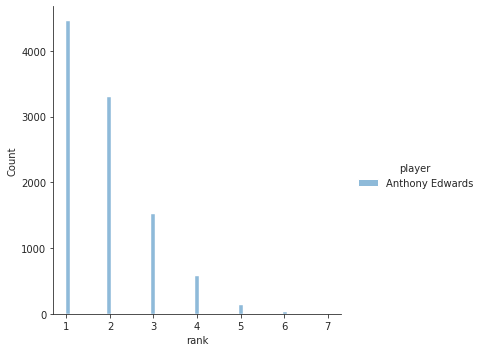

In [75]:
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.major.size": 8})
players = ['Anthony Edwards']
sns.displot(data=rank_df[rank_df.player.isin(players)],x='rank',kind='hist',hue='player')

An easier way to understand this distribution is to look at the cumulative probability. Remember when I said this model can be used in a similar way to survival analysis? This is what I'm talking about:

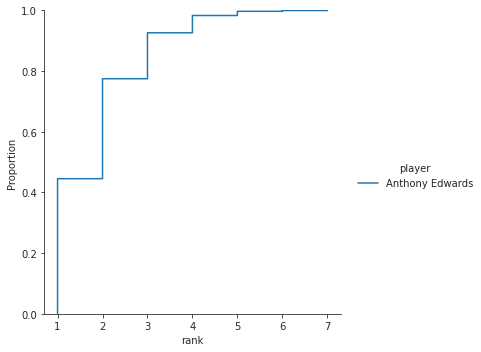

In [76]:
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.major.size": 8})
players = ['Anthony Edwards']
sns.displot(data=rank_df[rank_df.player.isin(players)],x='rank',kind='ecdf',hue='player')

From this we see Edwards has around a 45% chance of being taken first and around 80% to go top 2 and so on. Pretty neat! Now let's look at someone with a wider range of predictions, Saddiq Bey:

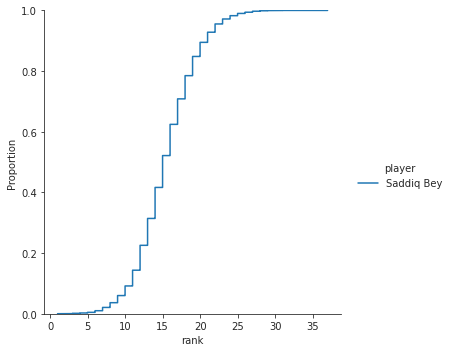

In [77]:
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.major.size": 8})
players = ['Saddiq Bey']
sns.displot(data=rank_df[rank_df.player.isin(players)],x='rank',kind='ecdf',hue='player')

Ooh isn't that cool? A very wide range indeed. Let's take a look at a more fringey player, Nick Richards:

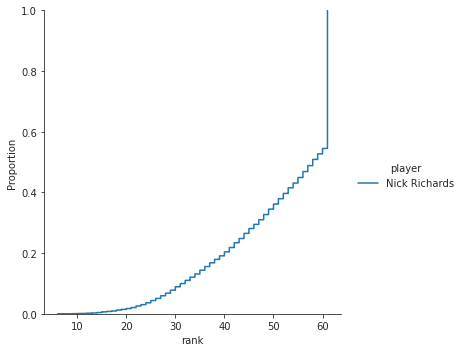

In [79]:
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.major.size": 8})
players = ['Nick Richards']
sns.displot(data=rank_df[rank_df.player.isin(players)],x='rank',kind='ecdf',hue='player')

Ok, so I should explain that in the simulation if a player is not drafted in the top 60, I just put him at 61, thus essentially making him an undrafted free agent (UDFA). These plots get kind of messy but before I'm done, here's one that has the top 10 guys in one chart.

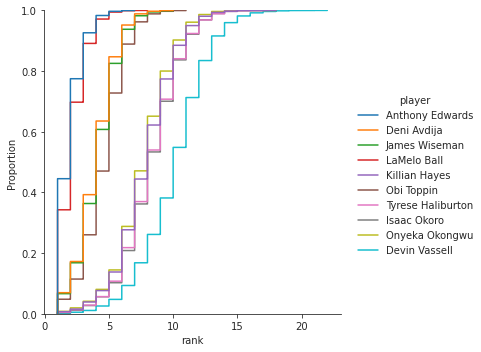

In [80]:
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.major.size": 8})
players = ['Anthony Edwards', 'LaMelo Ball', 'Deni Avdija', 'James Wiseman', 'Obi Toppin', 'Onyeka Okongwu',
          'Killian Hayes', 'Tyrese Haliburton', 'Isaac Okoro', 'Devin Vassell']
sns.displot(data=rank_df[rank_df.player.isin(players)],x='rank',kind='ecdf',hue='player')

Well, that's all I got for now. Be on the lookout (via my Twitter) for more t